In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 
import seaborn as sns
def ignore_warn(*args, **kwargs):
    pass
import warnings
warnings.warn = ignore_warn


### 一、读取数据

In [2]:
# 读取文件
df=pd.read_csv('时间序列数据.txt')


In [3]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

### 二、增加lag项

In [4]:
for i in range(1, 8):
    df["lag_{}".format(i)] = df.新增确诊.shift(i)
print("done")
df=df.fillna(0)

done


### 三、纠偏


 mu = 657.32 and sigma = 1070.09



Text(0.5, 1.0, 'confirmed distribution')

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22686 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30830 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35786 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22686 missing from cur

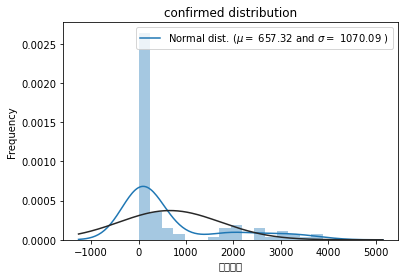

In [5]:
sns.distplot(df['新增确诊'] , fit=norm);
 
#得到均值和标准差
(mu, sigma) = norm.fit(df['新增确诊'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('confirmed distribution')

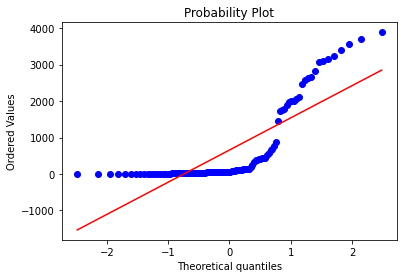

In [6]:
 #画QQ图
fig = plt.figure()
res = stats.probplot(df['新增确诊'], plot=plt)
plt.show();


 mu = 4.49 and sigma = 2.48



/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22686 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30830 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35786 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 22686 missing from cur

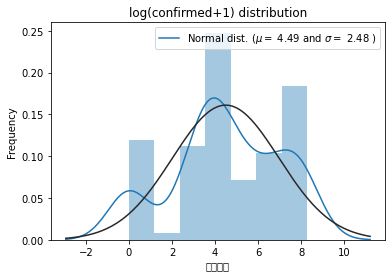

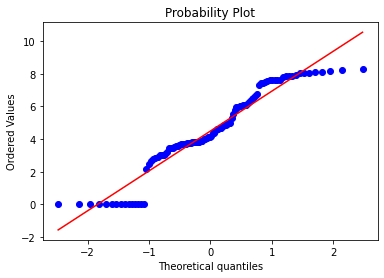

In [7]:
sns.distplot(np.log1p(df['新增确诊']) , fit=norm);
 
# 纠偏,对数化处理。
(mu, sigma) = norm.fit(np.log1p(df['新增确诊']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
 
#纠偏后再化分布图
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('log(confirmed+1) distribution')
 
#画QQ图
fig = plt.figure()
res = stats.probplot(np.log1p(df['新增确诊']), plot=plt)
plt.show();

In [8]:
#df.drop(['日期'], axis=1, inplace=True)
print("数据清洗前的特征变量的数量为:",len(df.columns)-1)
#对目标变量进行对数化纠偏
df["新增确诊"] = np.log1p(df["新增确诊"])
#对数值型特征变量进行对数化处理:1.过滤出数值型变量,2.计算偏度,3.对偏度大于0.75的数据进行对数化纠偏
#1.过滤出数值型变量
numeric_feats = df.dtypes[df.dtypes != "object"].index
#2.计算偏度
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#3.对偏度大于0.75的数据进行对数化纠偏
df[skewed_feats] = np.log1p(df[skewed_feats])
#4.对分类型变量进行one-hot编码,分类型变量会被横向展开为多个变量
df = pd.get_dummies(df)
#用均值填充空值
df = df.fillna(df.mean())
 
print("数据清洗后的特征变量的数量为:",len(df.columns)-1)

y = df['新增确诊']
X = df.drop(['新增确诊'], axis = 1)

数据清洗前的特征变量的数量为: 16
数据清洗后的特征变量的数量为: 16


#创建训练集和测试集

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.5, random_state = 0)

### 三、训练模型

In [9]:
X = df.drop(["新增确诊"], axis=1)
y = df.新增确诊

In [10]:
N = 50
X_train = X.iloc[:N,]
X_test = X.iloc[N:,]
y_train = y[:N]
y_test = y[N:]

# 利用弹性网络
from sklearn.model_selection import cross_val_score
cv_model = ElasticNetCV(l1_ratio=1.02, eps=1e-3, n_alphas=200, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=200, tol=0.006, cv=10, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

# 训练模型              
cv_model.fit(X_train, y_train)

# 计算最佳迭代次数、alpha和ratio
print('最佳 alpha: %.8f'%cv_model.alpha_)
print('最佳 l1_ratio: %.3f'%cv_model.l1_ratio_)
print('迭代次数 %d'%cv_model.n_iter_)

最佳 alpha: 0.04734089
最佳 l1_ratio: 1.020
迭代次数 48


In [11]:
# 输出结果
y_train_pred = cv_model.predict(X_train)
y_pred = cv_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_mse = mean_squared_error(y_train_pred, y_train)
test_mse = mean_squared_error(y_pred, y_test)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train r2 score:  0.9098747539184582
Test r2 score:  0.8258381350139532
Train RMSE: 0.9197
Test RMSE: 0.4641
